# Temperature and Salinity biases at slected depth Levels

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T/S fields at depth levels and compared agains observations (WOA18);

Temprature and salinity comparisons (model vs obs) at selected depth levels are grouped into the following regions: Global, Antarctic, and Arctic.

In [10]:
%matplotlib inline
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xycompare, polarcomparison
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools import m6toolbox
import yaml, os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Empty cell with "parameters" tag, papermill-provided parameters will be inserted below.

## Connecting to cluster

In [4]:
from dask.distributed import Client

if cluster_scheduler_address is None:
    pass
else:
    client = Client(cluster_scheduler_address)
    
    client

In [2]:
# Read in the yaml file
# diag_config_yml_path = "diag_config.yml"
# diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)

Casename is: gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.HBD.002


### This is the only cell that needs to be modified

In [11]:
file_stream = '.mom6.h_*.nc'
start_date = diag_config_yml['Avg']['start_date']
end_date = diag_config_yml['Avg']['end_date']
output_path = dcase.get_value('RUNDIR') 
# load WOA18 data
#woa_path = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/WOA18_remapping/'
obs_temp = xr.open_dataset(WOA18_temp_path,
                              decode_times=False).rename({'theta0': 'TEMP', 'z_l' : 'depth'});
obs_salt = xr.open_dataset(WOA18_salt_path,
                              decode_times=False).rename({'s_an': 'SALT', 'z_l' : 'depth'});

if not os.path.isdir('ncfiles'):
    os.system('mkdir ncfiles');

In [4]:
# read grid info
grd = MOM6grid(output_path+'/'+dcase.casename+'.mom6.static.nc');
grd_xr = MOM6grid(output_path+'/'+dcase.casename+'.mom6.static.nc', xrformat=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [5]:
cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

<Client: 'tcp://10.12.206.20:45785' processes=0 threads=0, memory=0 B>

In [12]:
# Compute the climatology dataset
#dset_climo = climo.stage()
variables = ['thetao', 'so', 'time', 'time_bnds']

def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    return ds[variables].resample(time="1Y", closed='left', \
           keep_attrs=True).mean(dim='time', keep_attrs=True)

ds = xr.open_mfdataset(output_path+'/'+dcase.casename+file_stream, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [13]:
%time ds = ds.sel(time=slice(start_date, end_date))

CPU times: user 1.7 ms, sys: 85 µs, total: 1.78 ms
Wall time: 1.79 ms


In [14]:
print('Time averaging...')
%time
temp = np.ma.masked_invalid(ds.thetao.mean('time').values)
salt = np.ma.masked_invalid(ds.so.mean('time').values)

Time averaging...
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


### Save netCDF files

In [17]:
attrs = {'description': 'model - obs at depth levels',
       'start_date': start_date,
       'end_date': end_date,
       'casename': dcase.casename,
       'obs': woa_path}

# create dataset to store results
thetao = xr.DataArray(temp, dims=['z_l','yh','xh'],
          coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh}).rename('thetao')
temp_bias = np.ma.masked_invalid(temp - obs_temp['TEMP'].values)
ds_thetao = xr.Dataset(data_vars={ 'thetao' : (('z_l','yh','xh'), thetao.values),
                        'thetao_bias' :     (('z_l','yh','xh'), temp_bias)},
                        coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_thetao,attrs)

ds_thetao.to_netcdf('ncfiles/'+str(dcase.casename)+'_thetao_time_mean.nc')
so = xr.DataArray(ds.so.mean('time'), dims=['z_l','yh','xh'],
          coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh}).rename('so')
salt_bias = np.ma.masked_invalid(so.values - obs_salt['SALT'].values)
ds_so = xr.Dataset(data_vars={ 'so' : (('z_l','yh','xh'), so.values),
                        'so_bias' :     (('z_l','yh','xh'), salt_bias)},
                        coords={'z_l' : ds.z_l, 'yh' : grd.yh, 'xh' : grd.xh})
m6toolbox.add_global_attrs(ds_so,attrs)
ds_so.to_netcdf('ncfiles/'+str(dcase.casename)+'_so_time_mean.nc')

In [18]:
client.close(); cluster.close()

### Potential temperature
#### Global

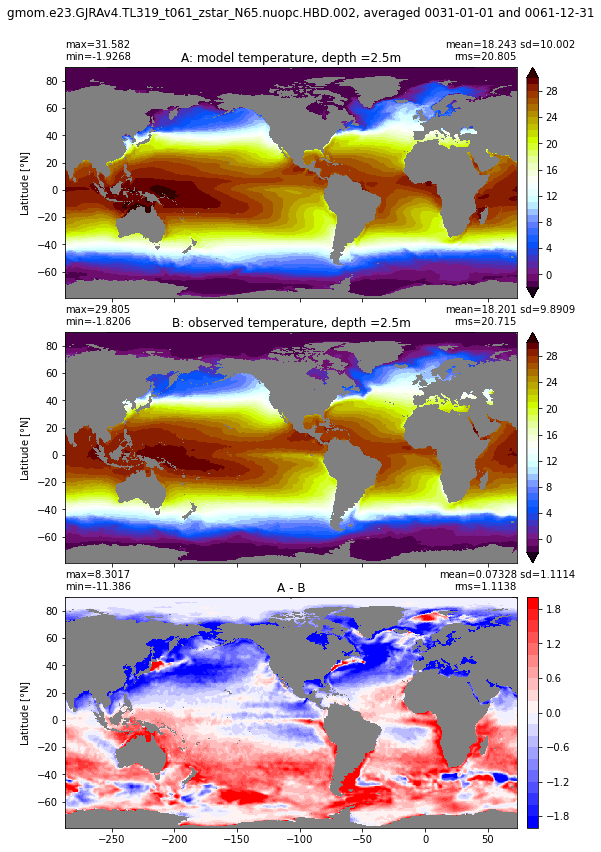

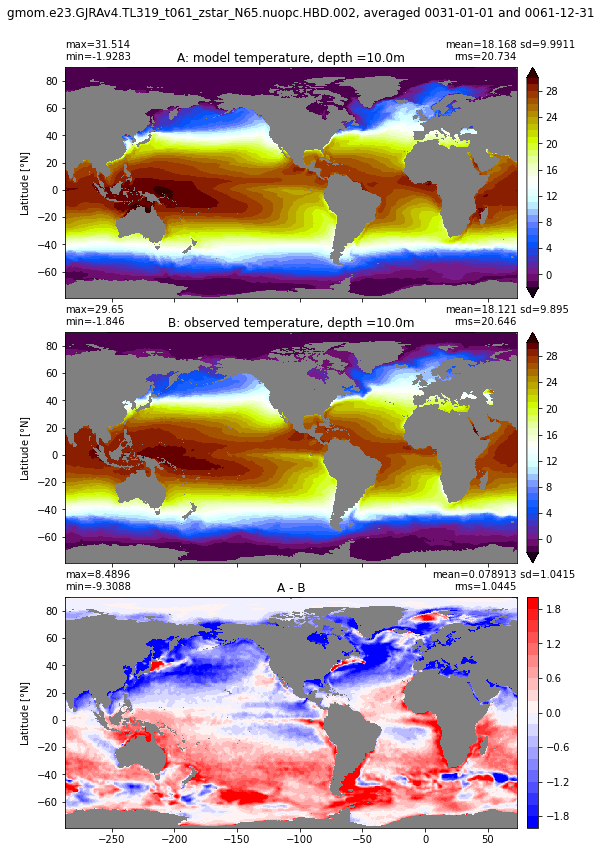

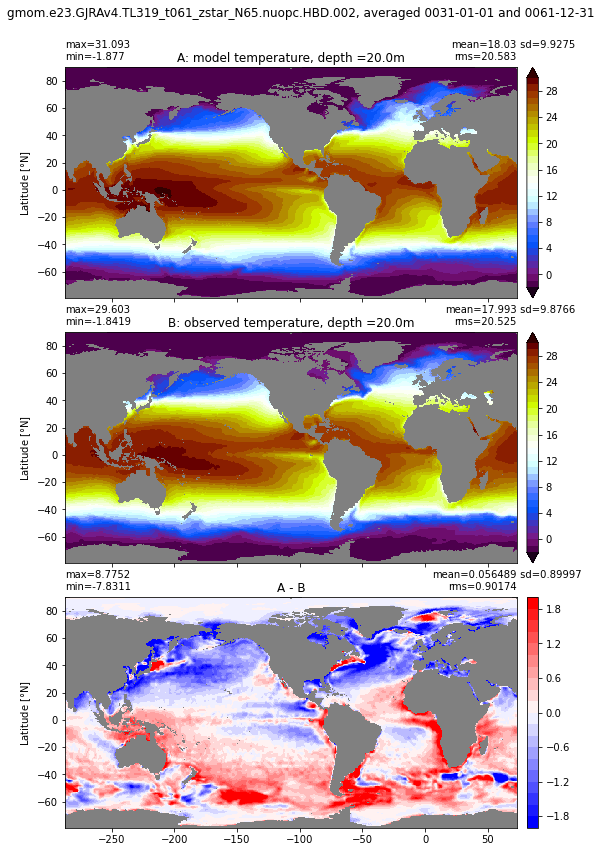

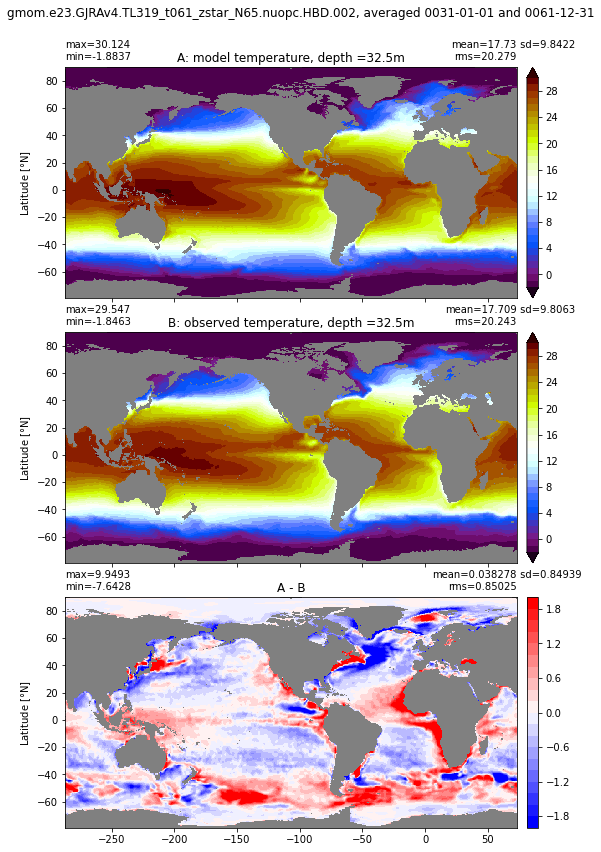

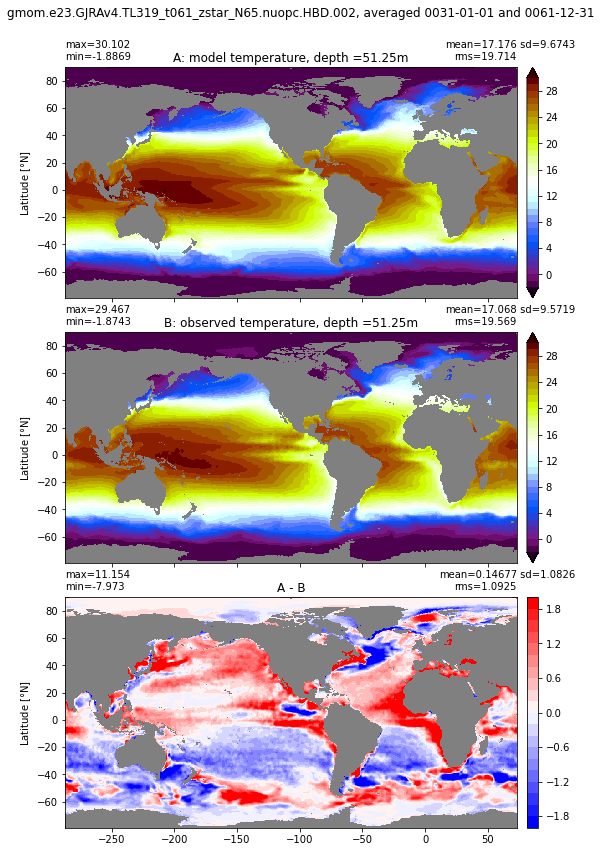

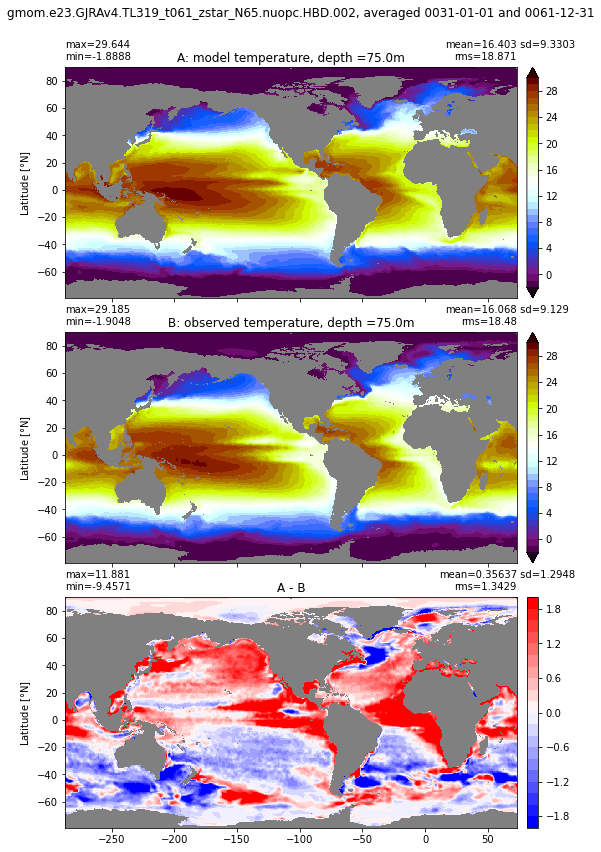

In [19]:
%matplotlib inline
km = len(obs_temp['depth'])
for k in range(km):
  if ds['z_l'][k].values < 100.0:
    temp_obs = np.ma.masked_invalid(obs_temp['TEMP'][k,:].values)
    xycompare(temp[k,:] , temp_obs, grd.geolon, grd.geolat, area=grd.area_t,
            title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed temperature, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            suptitle=dcase.casename + ', averaged '+str(start_date)+ ' and ' +str(end_date),
            clim=(-1.9,30.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)

#### Antarctica

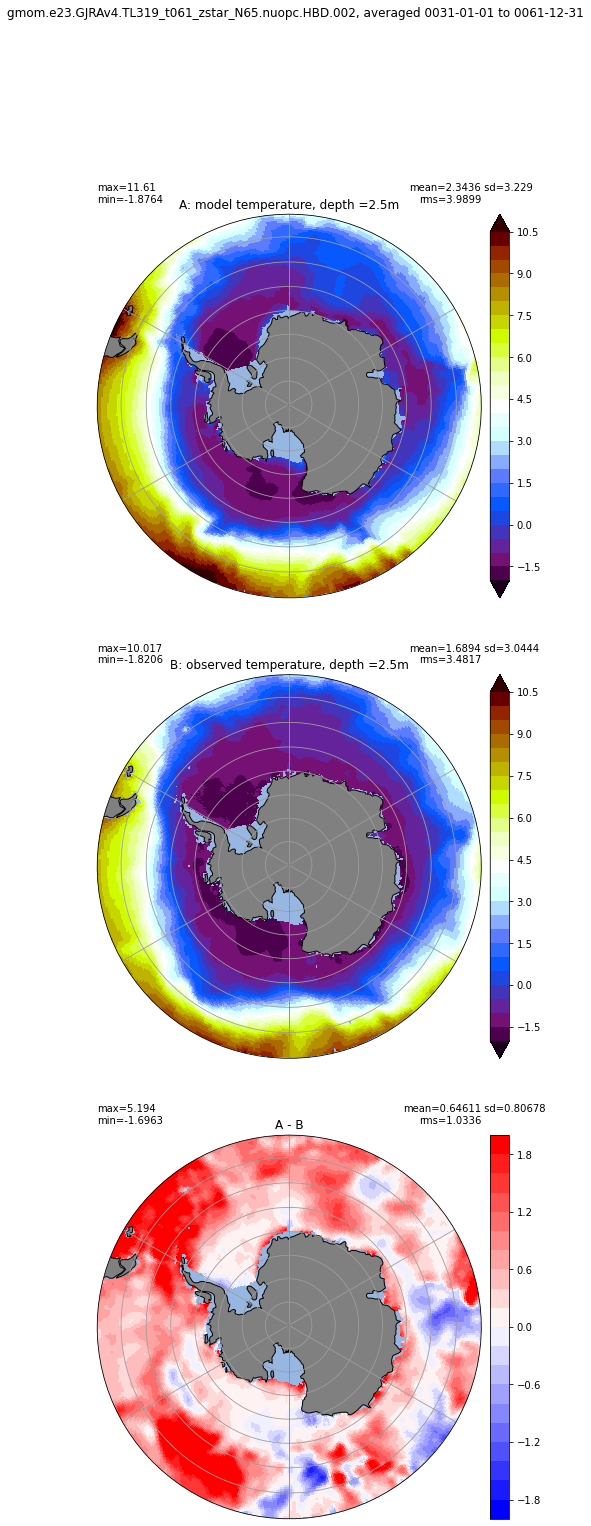

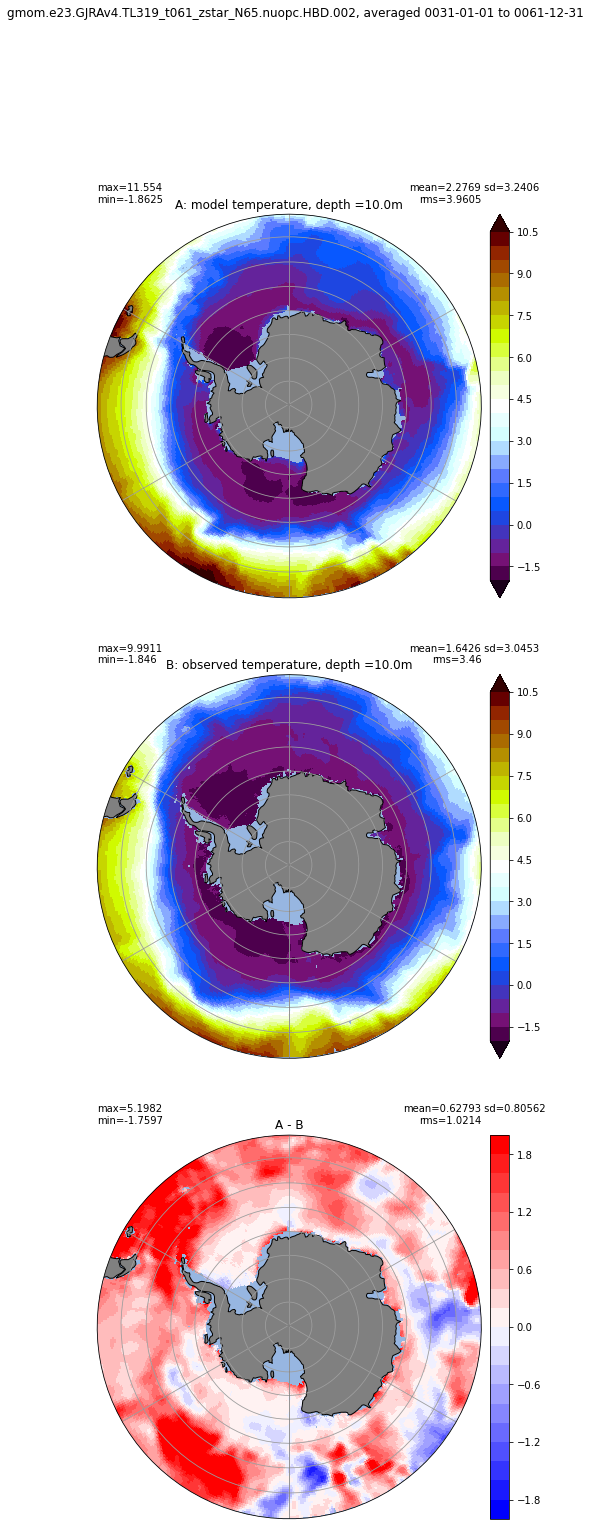

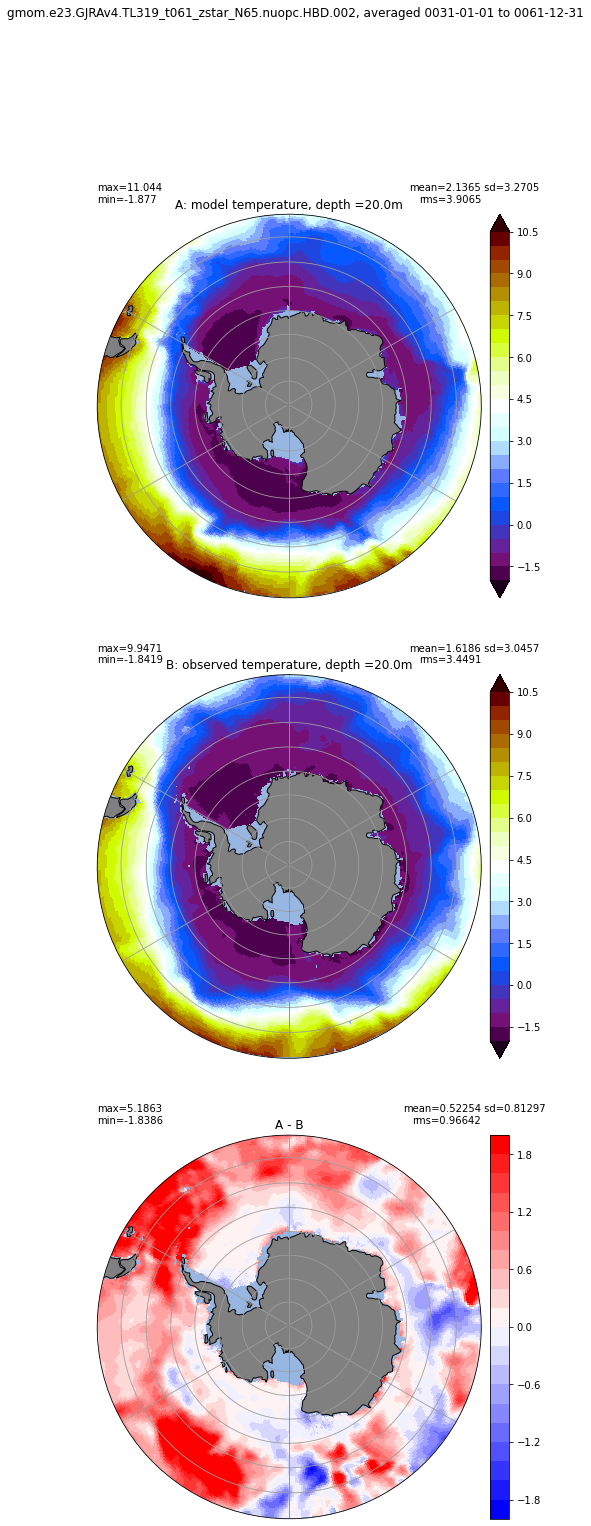

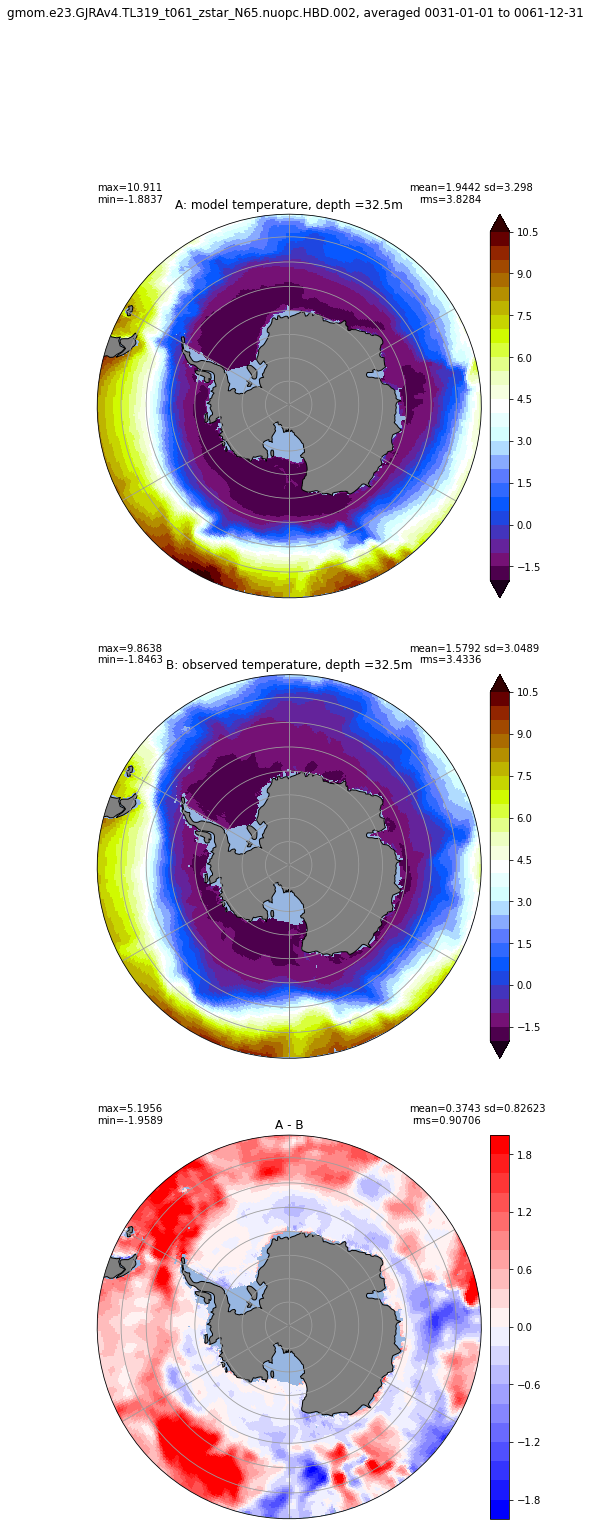

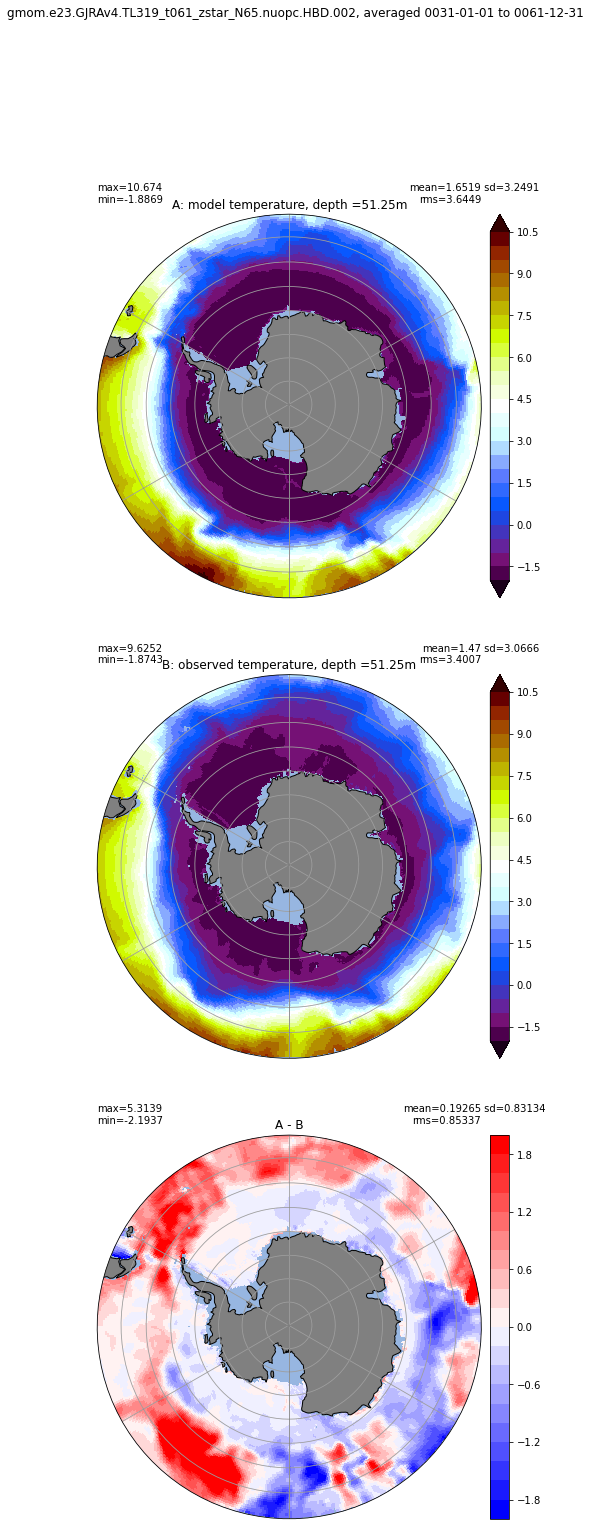

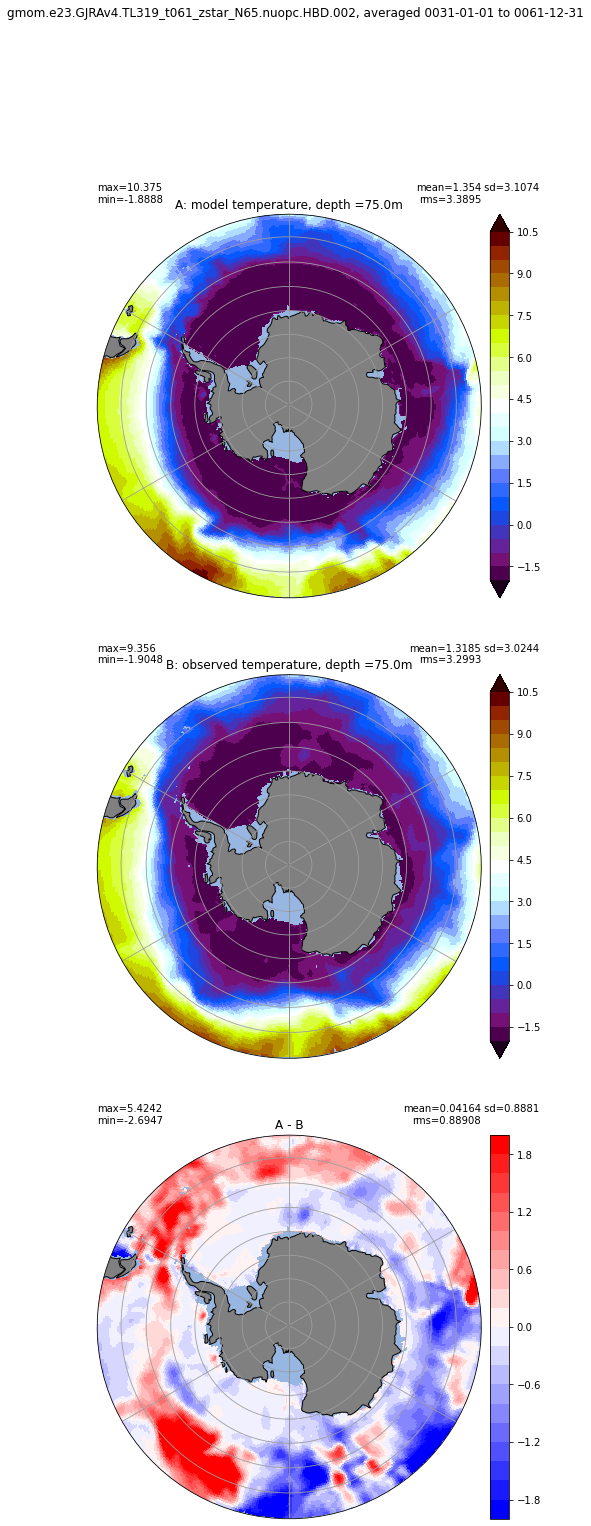

In [20]:
# loop over depths and compare TS fields
km = len(obs_temp['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    temp_obs = np.ma.masked_invalid(obs_temp['TEMP'][k,:].values)
    polarcomparison(temp[k,:] , temp_obs, grd,
              title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
              title2 = 'observed temperature, depth ='+str(obs_temp['depth'][k].values)+ 'm',
              extend='both', dextend='neither', clim=(-1.9,10.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
              suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
              proj='SP', show= True)

#### Arctic

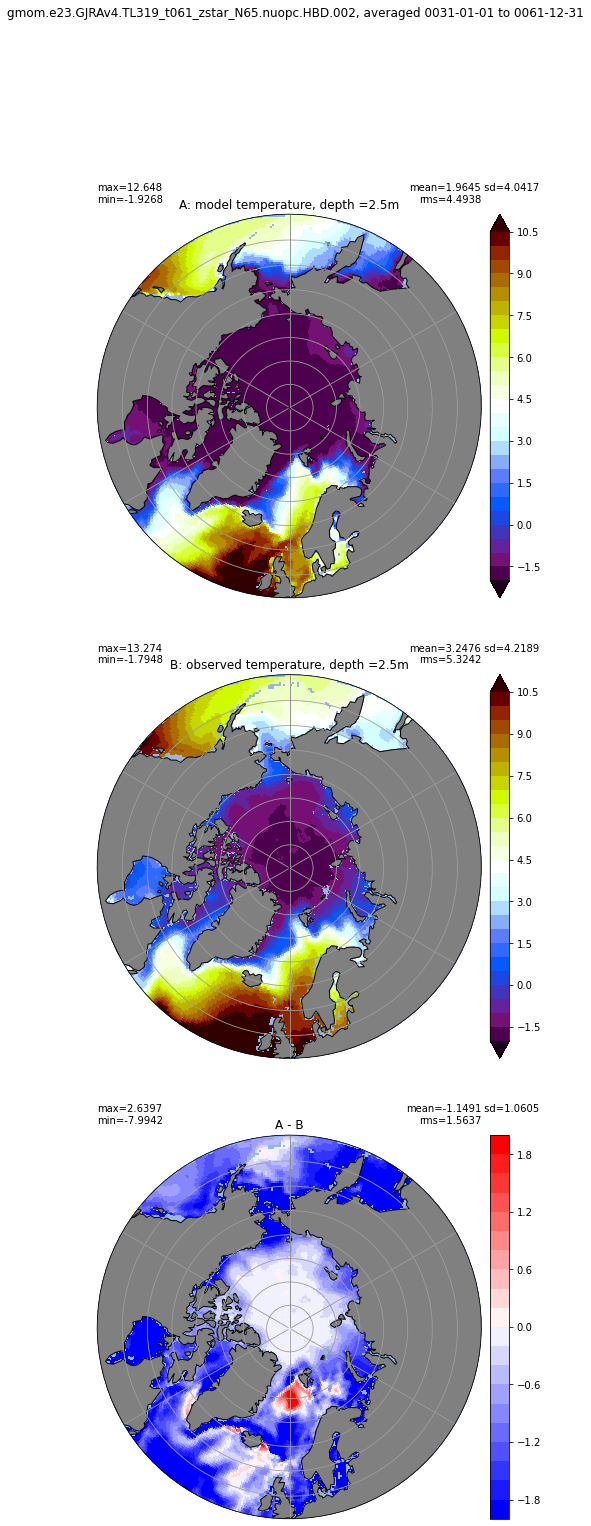

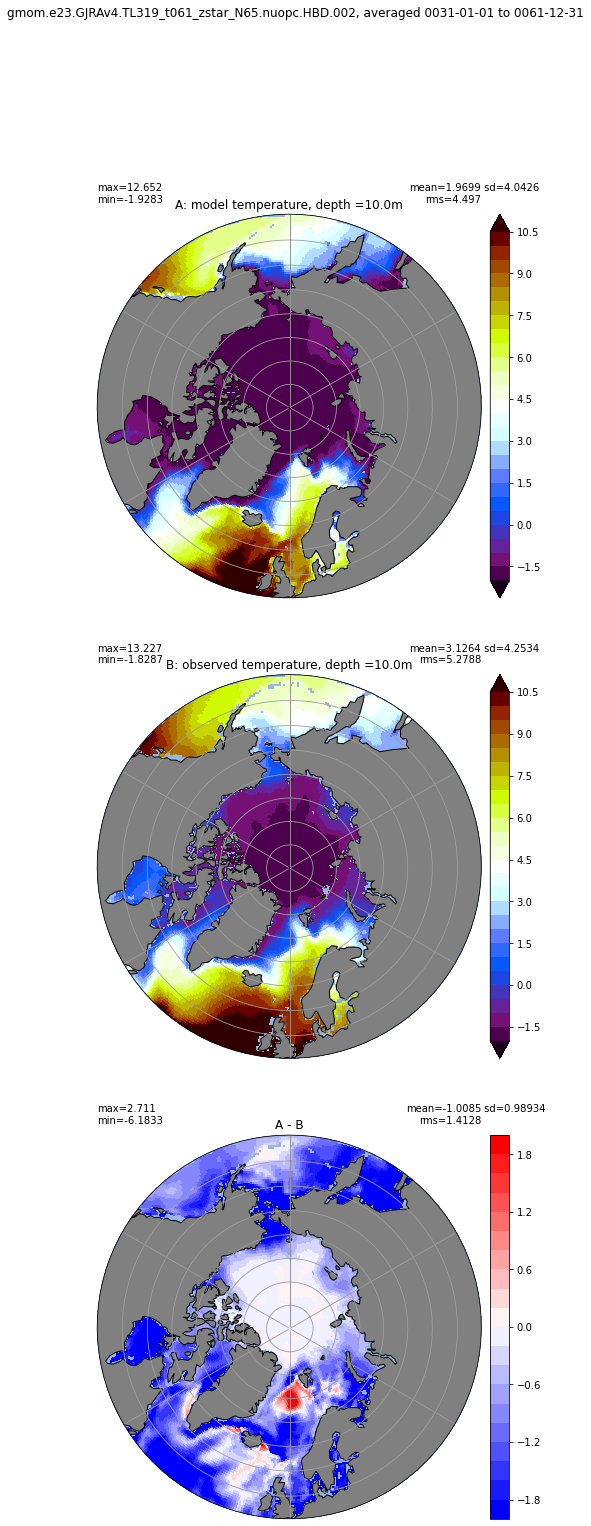

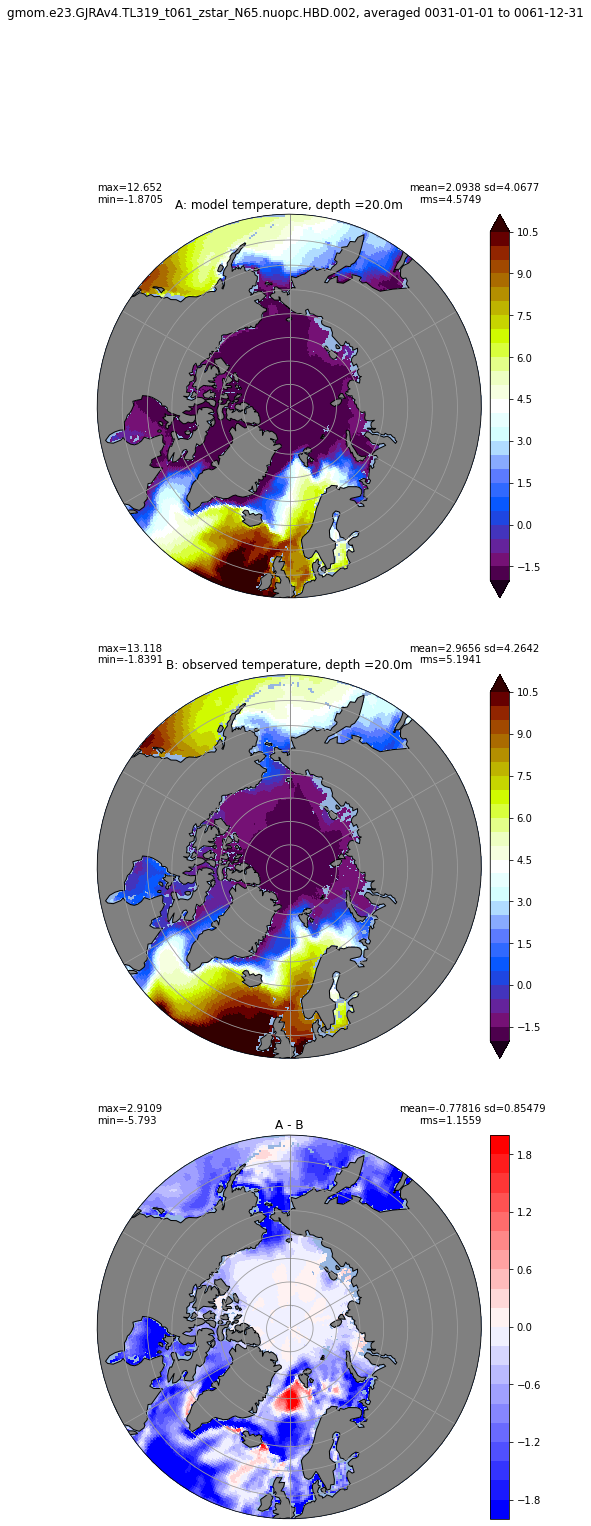

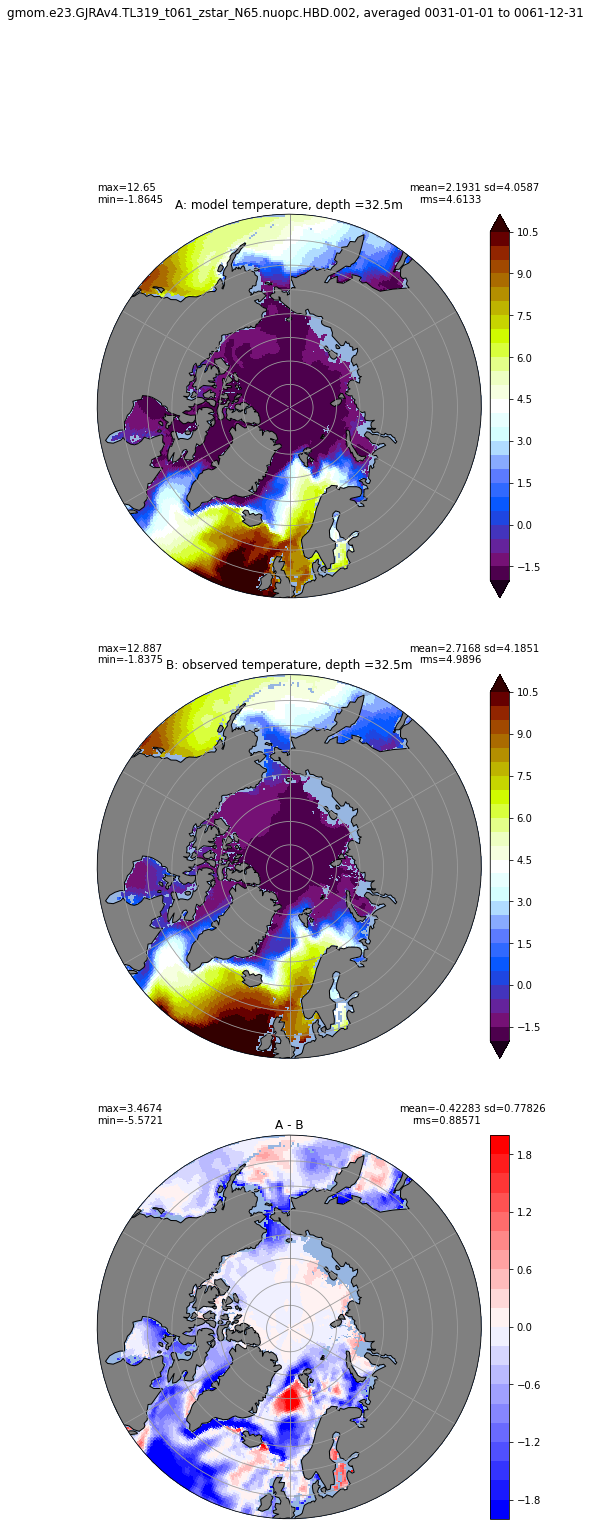

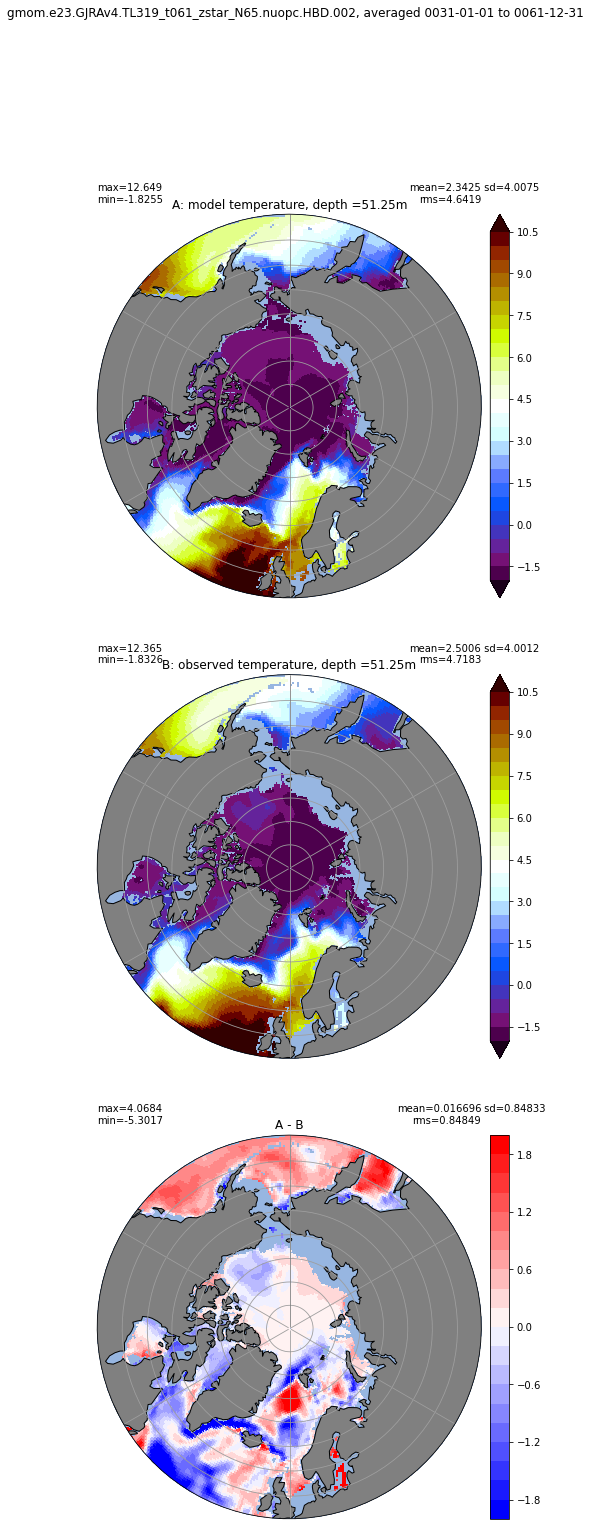

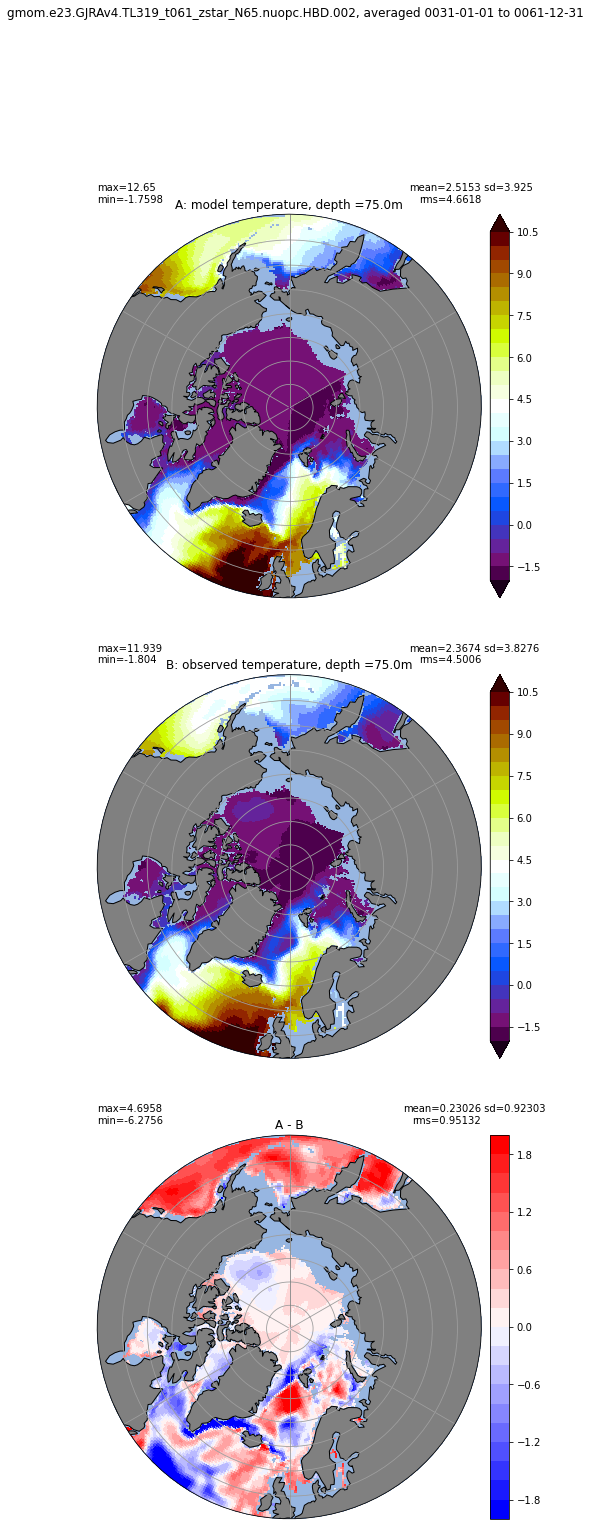

In [21]:
# loop over depths and compare TS fields
km = len(obs_temp['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    temp_obs = np.ma.masked_invalid(obs_temp['TEMP'][k,:].values)
    polarcomparison(temp[k,:] , temp_obs, grd,
            title1 = 'model temperature, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed temperature, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            extend='both', dextend='neither', clim=(-1.9,10.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
            suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
            proj='NP', show= True)

### Salinity
#### Global

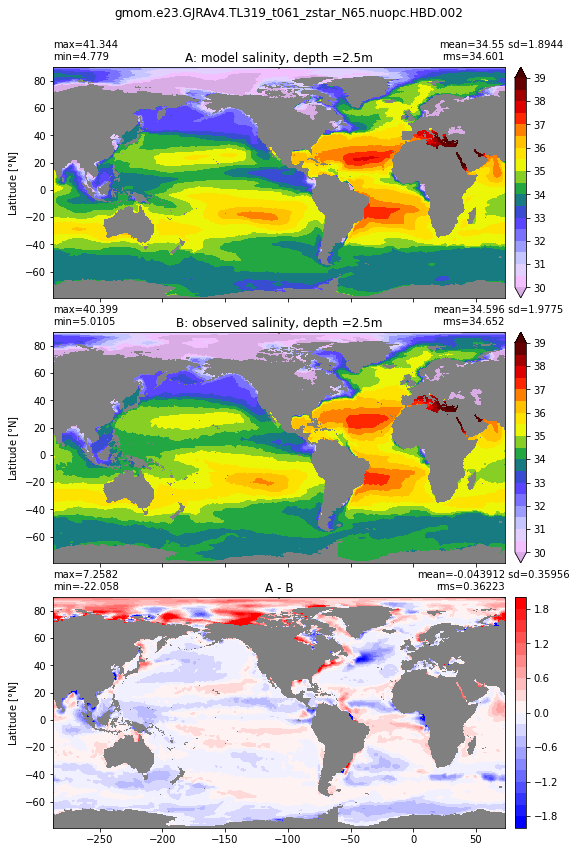

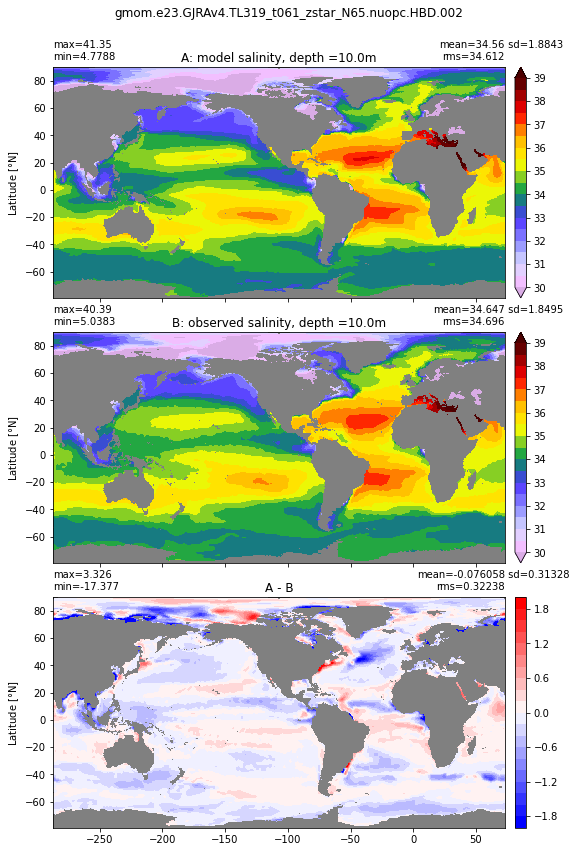

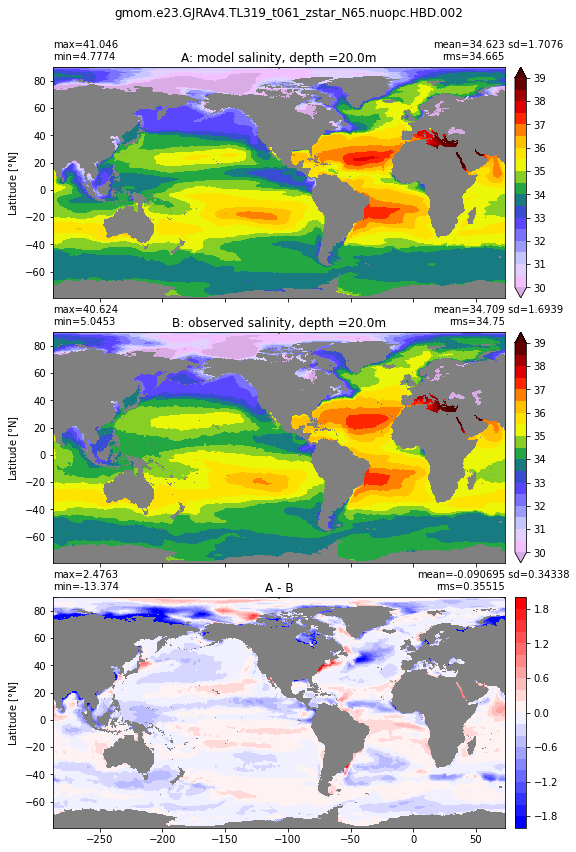

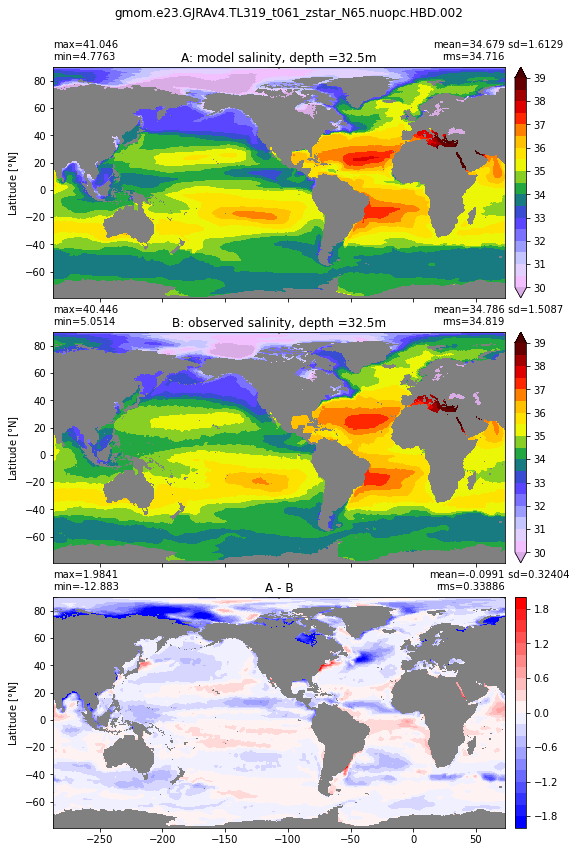

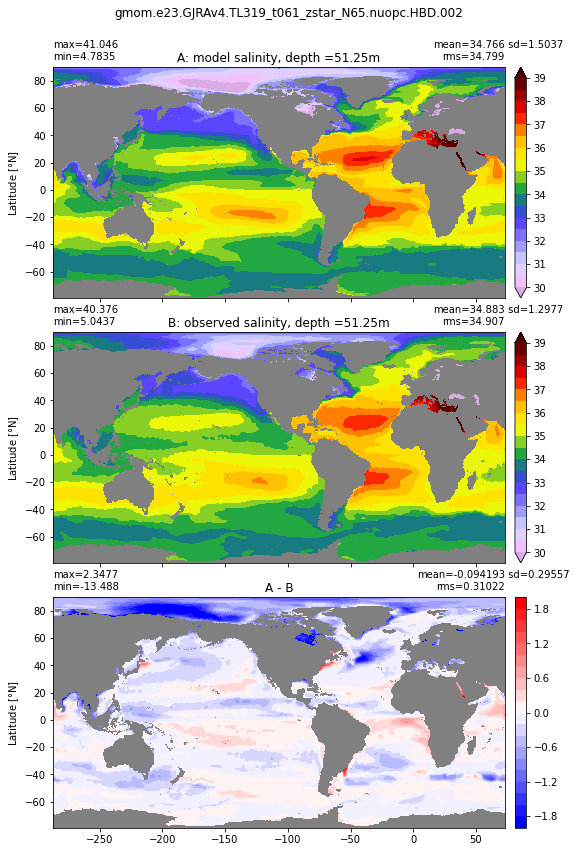

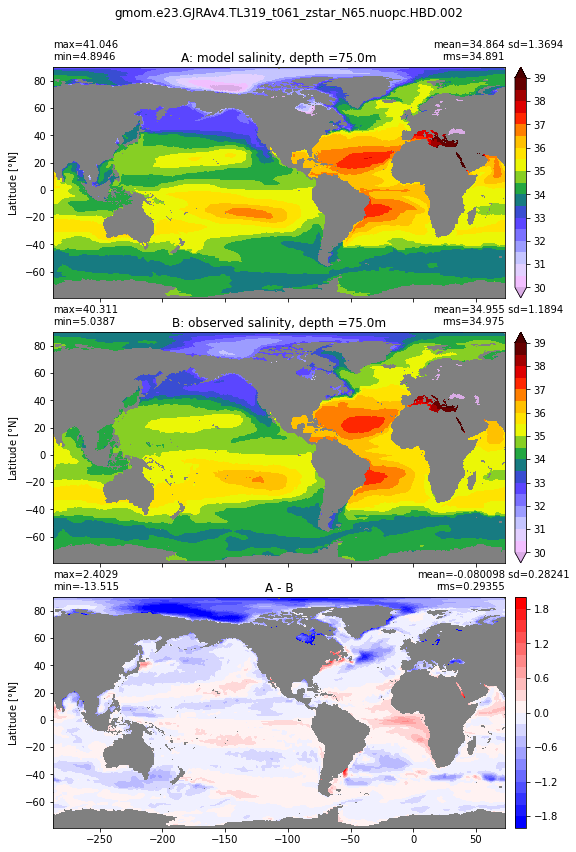

In [22]:
%matplotlib inline
km = len(obs_temp['depth'])
for k in range(km):
  if ds['z_l'][k].values < 100.0:
    salt_obs = np.ma.masked_invalid(obs_salt['SALT'][k,:].values)
    xycompare( salt[k,:] , salt_obs, grd.geolon, grd.geolat, area=grd.area_t,
            title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed salinity, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            suptitle=dcase.casename, clim=(30,39.), dcolormap=plt.cm.bwr,
            extend='both', dextend='neither', dlim=(-2,2),
            show= True)

#### Antarctica

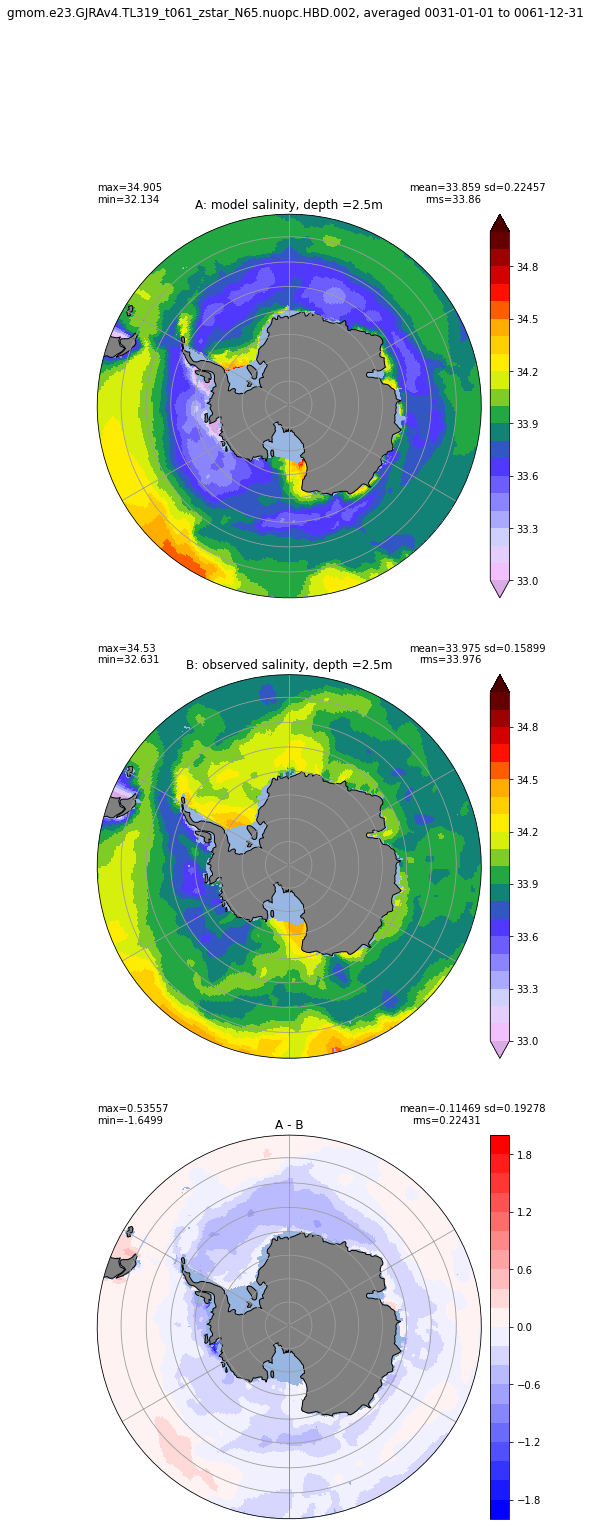

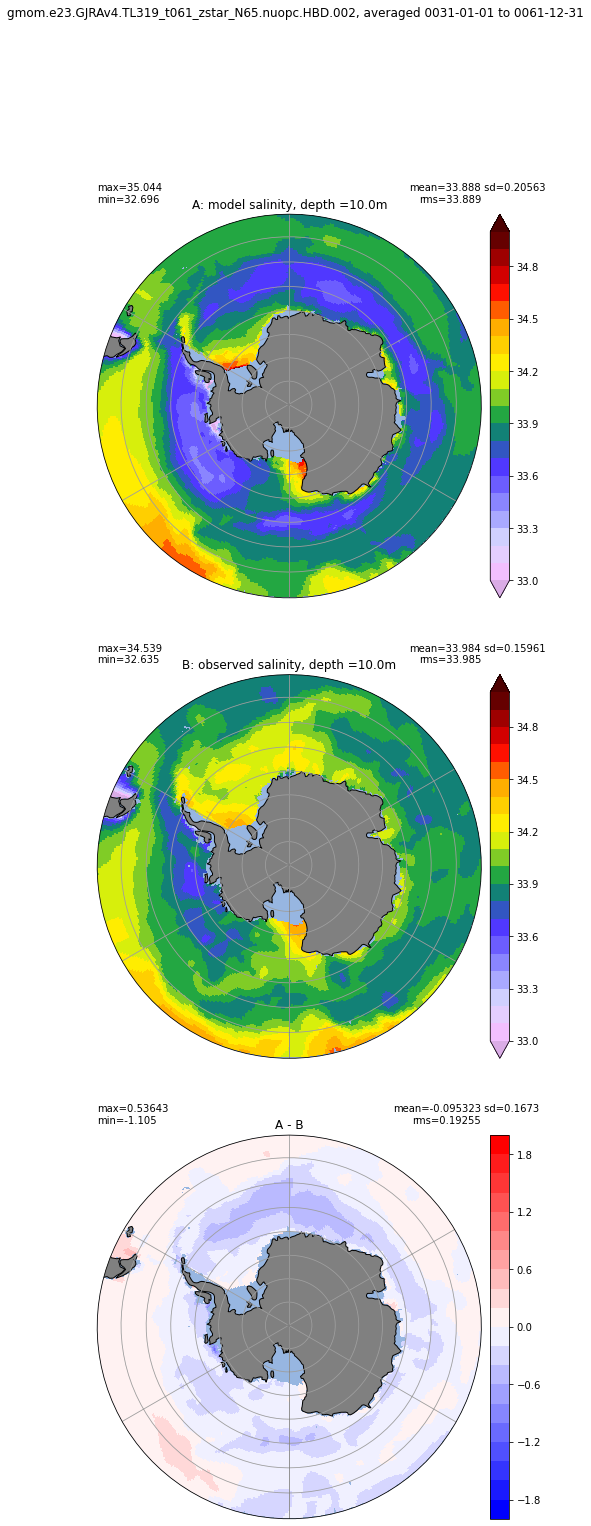

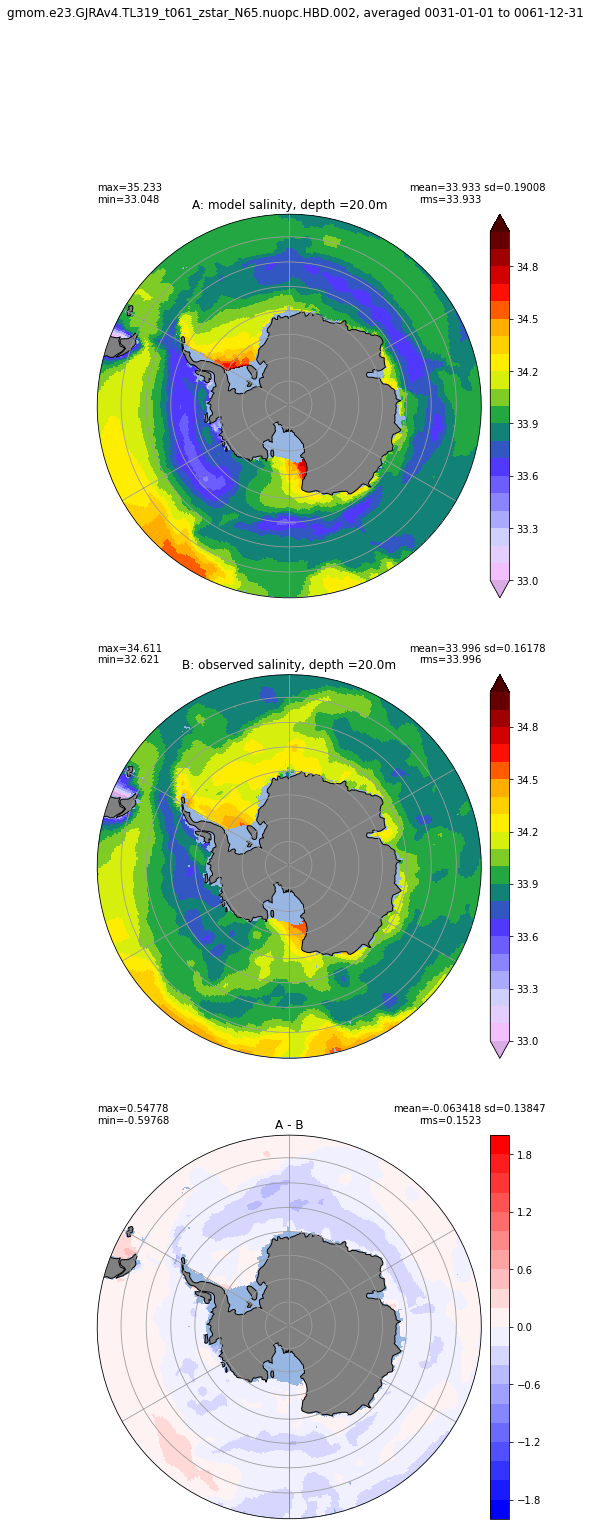

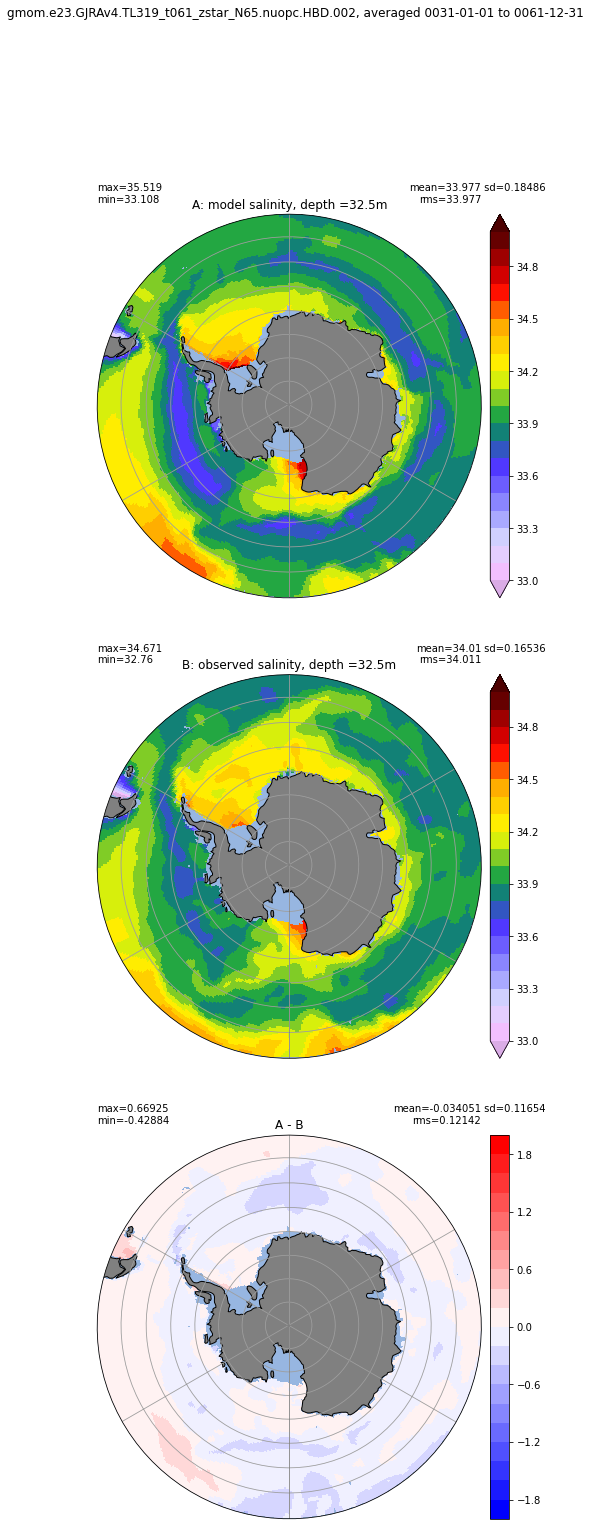

In [ ]:
# loop over depths and compare TS fields
km = len(obs_temp['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    salt_obs = np.ma.masked_invalid(obs_salt['SALT'][k,:].values)
    polarcomparison( salt[k,:] , salt_obs, grd,
              title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
              title2 = 'observed salinity, depth ='+str(obs_temp['depth'][k].values)+ 'm',
              extend='both', dextend='neither', clim=(33.,35.), dlim=(-2,2), dcolormap=plt.cm.bwr,
              suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
              proj='SP', show= True)

#### Arctic

In [ ]:
# loop over depths and compare TS fields
km = len(obs_temp['depth'])
for k in range(km):
  if (ds['z_l'][k].values < 100.):
    salt_obs = np.ma.masked_invalid(obs_salt['SALT'][k,:].values)
    polarcomparison( salt[k,:] , salt_obs, grd,
            title1 = 'model salinity, depth ='+str(ds['z_l'][k].values)+ 'm',
            title2 = 'observed salinity, depth ='+str(obs_temp['depth'][k].values)+ 'm',
            extend='both', dextend='neither', clim=(32.,34.5), dlim=(-2,2), dcolormap=plt.cm.bwr,
            suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
            proj='NP', show= True)